# Sunshine Levels on Worker Productivity

### Dependencies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!pip install linearmodels
from linearmodels import PanelOLS
from linearmodels.iv.model import IV2SLS
import statsmodels.api as sm
import os

# (TODO) Note: Edit using local folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
folder_path = '/content/drive/MyDrive/metrics_paper'
os.chdir(folder_path)

### Processing Industry GDP and Sunshine Irradiance Levels

In [6]:
import locale 

def get_solar_data(solar_csv_file):
  ''' given csv file of the sunshine irridance convert into df'''   
  solar_data = pd.read_csv(solar_csv_file) 
  solar_data.drop("StateFIPS", axis=1, inplace=True)
  solar_data.drop('Data Comment', axis=1, inplace=True)
  solar_data.drop('Unnamed: 5', axis=1, inplace=True)
  solar_data['Sunshine_Irradiance'] = solar_data['Value'].apply(lambda x: float(x.replace(",", "")))
  solar_data.drop('Value', axis=1, inplace=True)
  return solar_data 

solar_df = get_solar_data("2002_2012_State_Solar_Irridance.csv")
STATES_SET = set(solar_df['State'])
YEARS_SET = set(solar_df['Year'].values)
solar_df.set_index(['State', "Year"], inplace=True)

def get_state_gdp(csv_file):
  ''' given csv file (not file path) (2012 chained, yearly), process into
  dataframe with Year/State multi-index'''
  state_gdp_data = pd.read_csv(csv_file)
  state_gdp_data = state_gdp_data[state_gdp_data['GeoName'].isin(STATES_SET)]
  
  #add stubname and rename columns
  col_with_stub = ['State' if 'GeoName' in colname else 'Y' + colname for colname in list(state_gdp_data.columns)] 
  state_gdp_data.columns = col_with_stub
  state_gdp_data = pd.wide_to_long(state_gdp_data, ["Y"], i="State", j="Year")
  state_gdp_data.columns = ["GDP_2012Mil"]
  #group by state and year
  state_gdp_data = state_gdp_data.groupby(['State', 'Year']).first()
  return state_gdp_data


In [7]:
#convert the state string to 
set_continental_states = set(STATES_SET)
abbrev_to_state = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

def convert_code_to_state(x):
  if x in abbrev_to_state.values():
    return x 
  return abbrev_to_state[x[:2]]

from datetime import datetime
#takes in string of datetime
def convert_date_to_int(x):
  if isinstance(x, int):
    return x
  if isinstance(x, str):
    dt = datetime.strptime(x, '%Y-%m-%d')
    return int(dt.year)
  return int(x.strftime('%Y'))

In [8]:
import os 

INDUSTRY_FOLDER = "industry_gdp/"

def process_naics(filename, folder=INDUSTRY_FOLDER, states_set=STATES_SET, years_set=YEARS_SET, gdp_name=None):
  ''' given csv file (not file path) in industry_gdp folder (2012 chained, yearly), process into
  dataframe with Year/State multi-index'''
  if folder is not None:
    file_path = os.path.join(folder, filename)
  else:
    file_path = filename
  df = pd.read_csv(file_path)

  df['State'] = df['State'].apply(convert_code_to_state)
  #drop all states that are not in the original continental states
  df = df[df['State'].isin(states_set)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}")

  #convert the date to the year
  df['Date'] = df['Date'].apply(convert_date_to_int)
  industry_name = filename.split("_")[0]

  df = df[['Date', 'GDP', 'State']]
  df = df[df['Date'].isin(years_set)]
  if gdp_name is not None:
    gdp_column_name = gdp_name 
  else:
    gdp_column_name = f'{industry_name}_GDP_2012Mil'
  df.rename(columns={"GDP": gdp_column_name, "Date": "Year"}, inplace=True)
  
  df = df.set_index(['State', "Year"])
  return df

### Regression without Covariates

In [9]:
def get_gdp_sunshine_df():
  state_gdp_df = get_state_gdp("StateLevelGDP.csv")
  df_list = [solar_df, state_gdp_df]
  #get gdp for each industry
  for industry_gdp_csv in os.listdir(INDUSTRY_FOLDER):
    if "NAICS" not in industry_gdp_csv:
      continue 
    industry_df = process_naics(industry_gdp_csv)
    df_list.append(industry_df)
  gdp_sunshine_df = pd.concat(df_list, axis=1)
  return gdp_sunshine_df

In [10]:
SAVE_FOLDER = 'regression_output'

def save_fit_summary(fit, output_var, exog_vars, entity_effects, time_effects, save_folder, cov_type="robust_hetero"): 
  #given PanelOLS fit, save the fit summary as text file
  exog_string = "_".join(exog_vars)  
  title_name = f'{output_var}_{exog_string}_entity_{entity_effects}_time_{time_effects}_cov_{cov_type}_fit.txt'
  file_path = os.path.join(save_folder, title_name)
  #save fit as text file 
  text_file = open(file_path, "w")
  n = text_file.write(fit.summary.as_csv())
  text_file.close()   
  return 

def regression_all_gdp(df, entity_effects=False, time_effects=True, exog_vars = ["Sunshine_Irradiance"], save_folder=SAVE_FOLDER):
  #run a regression for each GDP (one for state and one for each industry)
  exog_df = sm.add_constant(df[exog_vars])
  gdp_output_variables = [colname for colname in df.columns if "GDP" in colname]
  for output_var in gdp_output_variables:
    model = PanelOLS(df[output_var], exog_df, entity_effects = entity_effects, time_effects = time_effects)
    fit = model.fit()
    save_fit_summary(fit, output_var, exog_vars, entity_effects, time_effects, save_folder)
    print(f"Saved: {output_var}")
  return fit

In [11]:
gdp_sun_df = get_gdp_sunshine_df()
regression_all_gdp(gdp_sun_df, entity_effects=False, time_effects=True)

### Processing Covariates

#### Agriculture


In [12]:
agriculture_df = process_naics('NAICS111-112_gdp_states.csv',folder="covariates", states_set=STATES_SET, years_set=YEARS_SET)
agriculture_df.columns=['Agriculture_Product_2012Mil']

#### Natural Disaster

In [13]:
def convert_generic_to_df(df):
  #convert a generic dataframe with "State", "Year", "Average_Cost"
  df['State'] = df['State'].apply(convert_code_to_state)
  #drop all states that are not in the original continental states
  df = df[df['State'].isin(STATES_SET)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}")

  #convert the date to the year
  df['Year'] = df['Year'].apply(convert_date_to_int)

  df = df[df['Year'].isin(YEARS_SET)]
  df.set_index(['State', "Year"], inplace=True)
  return df

In [14]:
def avg_from_range(range_string):
  lower, upper = range_string.split("-")[0], range_string.split("-")[1]
  return np.mean([int(lower), int(upper)])

def get_nat_df():
  nat_df = pd.read_csv("covariates/natdisasters-costrange-bystate.csv")
  nat_df.rename(columns={"state": "State", 'All Disasters Cost Range':"Cost_Range"}, inplace=True)
  nat_df['Nat_Average_Cost'] = nat_df["Cost_Range"].apply(avg_from_range)
  #convert to average cost (from cost range)
  nat_df.drop('Unnamed: 0', axis=1, inplace=True)
  nat_df.drop('Cost_Range', axis=1, inplace=True)
  return convert_generic_to_df(nat_df)

In [ ]:
nat_df = get_nat_df()
gdp_sun_covariate_df = pd.concat([gdp_sun_df, nat_df, agriculture_df], axis=1)

### Regression with Natural Disaster and Agricultural GDP

In [ ]:
regression_all_gdp(gdp_sun_covariate_df, entity_effects=False, time_effects=True, exog_vars = ["Sunshine_Irradiance", "Nat_Average_Cost", "Agriculture_Product_2012Mil"], save_folder="regression_covariate")

### IV Regression

##### Format the instruments

In [17]:
def convert_state_year_to_df(df):
  #convert a generic dataframe with  "Year" columsn and first col as "State"
  df.rename(columns={ df.columns[0]: "State" }, inplace = True)

  #drop all states that are not in the original continental states
  df = df[df['State'].isin(STATES_SET)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}")

  #convert the date to the year
  df['Year'] = df['Year'].apply(convert_date_to_int)

  df = df[df['Year'].isin(YEARS_SET)]
  df.set_index(['State', "Year"], inplace=True)
  return df

In [51]:
def process_state_date_df(df, value_name, states_set=STATES_SET, dates_set=YEARS_SET):
  #processes dataframe whose first column is state (the column headers are the years)
  df.rename(columns={ df.columns[0]: "State" }, inplace = True)
  df = df[df['State'].isin(states_set)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}")
    print(f"Missing {' '.join(states_set.difference(set(df['State'].values)))}")
  df.set_index("State", inplace=True)

  col_subset = []
  for i,colname in enumerate(df.columns.values):
    if colname.isalpha() and colname != "State":
      col_subset.append(i)
    elif dates_set is None:
      col_subset.append(i)
    elif int(colname) in dates_set:
      col_subset.append(i)

  df = df.iloc[:, col_subset]
  
  new_cols = ['Y' + colname if "State" not in colname else colname for colname in df.columns.values]
  df.columns = new_cols
  df["State"] = df.index
  return_df = pd.wide_to_long(df, ['Y'], i="State", j="Year")

  return_df.columns = [value_name]
  return_df.sort_index(inplace=True)
  return return_df

In [20]:
def run_iv(gdp_sun_df, save_folder):
  cloud_values = pd.read_csv('cloud/state_cloud_cover_values.csv')
  IV_INS = process_state_date_df(cloud_values, "Cloud Cover")
  exog_df = pd.concat([nat_df, agriculture_df], axis=1)
  exog_df = add_region_covariate(exog_df)
  exog_df = sm.add_constant(exog_df)
  gdp_output_variables = [colname for colname in gdp_sun_df.columns if "GDP" in colname]
  for output_var in gdp_output_variables:
    iv_regression = IV2SLS(gdp_sun_df[output_var], exog_df, solar_df, instruments=IV_INS)
    iv_regression_fit = iv_regression.fit()
    save_fit_summary(iv_regression_fit, output_var, ["Irradiance", "Natural_Disaster", "Agriculture",'Great Lakes','Mideast','New England','Plains','Rocky Mountain','Southeast','Southwest' ], False, False, save_folder=save_folder)
  return iv_regression_fit



In [ ]:
run_iv(gdp_sun_df, "iv_regression/regional")

#### IV Relevance Assumption

col subset is [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]


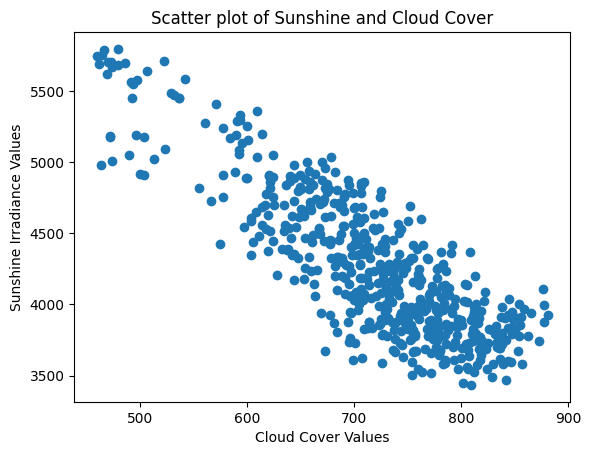

array([[ 1.        , -0.84255479],
       [-0.84255479,  1.        ]])

In [ ]:
cloud_values = pd.read_csv('cloud/state_cloud_cover_values.csv')
IV_INS = process_state_date_df(cloud_values, "Cloud Cover")
cloud_cover = IV_INS['Cloud Cover'].values 
sunshine_values = gdp_sun_df['Sunshine_Irradiance'].values
plt.scatter(cloud_cover, sunshine_values)
plt.xlabel("Cloud Cover Values")
plt.ylabel("Sunshine Irradiance Values")
plt.title("Scatter plot of Sunshine and Cloud Cover")
plt.show()

np.corrcoef(cloud_cover, sunshine_values)

### Average Wage over GDP


In [ ]:
#process wage share GDP data
wage_share_raw = pd.read_csv("states_laborshare_data/wage_share_of_GDP.csv")

#average wage divided by GDP. This metric is deprecated and note used in the final paper.
average_wage_over_gdp_df = process_state_date_df(wage_share_raw, "wage_share", states_set=STATES_SET, dates_set=YEARS_SET)

### Labor Share of GDP

In [ ]:
#data folder
labor_data_folder = "covariates/Quarterly_Total_Wage_Per_State_In_Thousands"

def get_quarterly_state_wages_csv():
  state_wages_dict = {}
  years = []

  for file in os.listdir(labor_data_folder):
    state_name = file.split("_")[0] 
    state_name = state_name.replace("-", " ")
    file_path = os.path.join(labor_data_folder, file)
    state_df = pd.read_excel(file_path, skiprows=13)
    years = state_df['Year'].values[:-1]
    q1_values = state_df['Annual'].values[:-1] 
    q2_values = state_df['Annual'].values[:-1]
    q3_values = state_df['Annual'].values[:-1]
    q4_values = state_df['Annual'].values[:-1]
    inter = np.ravel(np.column_stack((q1_values, q2_values, q3_values, q4_values)))
    inter = inter / 1000 
    state_wages_dict[state_name] = inter

  state_wages = pd.DataFrame(state_wages_dict)
  dates = np.ravel([(f'01-{year}', f'04-{year}', f'07-{year}', f'10-{year}') for year in years])
  state_wages['Dates'] = dates 
  state_wages.set_index('Dates', inplace=True)
  state_wages = state_wages.T
  state_wages.to_csv('covariates/quarterly_state_total_wages_millions.csv')
  return state_wages


In [ ]:
#Processes dataframe whose first column is state (the column headers are the years)
def quarter_state_date_df(df, value_name, states_set=STATES_SET):
  df.rename(columns={ df.columns[0]: "State" }, inplace = True)
  df = df[df['State'].isin(states_set)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}")
    print(f"Missing {' '.join(states_set.difference(set(df['State'].values)))}")
  df.set_index("State", inplace=True)

  #rename columns to work with wide to long
  new_cols = []
  for col in df.columns:
    date = datetime.strptime(col, '%m-%Y')
    if date.month < 10:
      new_col = f'{date.year}0{date.month}'
    else:
      new_col = f'{date.year}{date.month}'

    new_cols.append(new_col)
  df.columns = new_cols

  col_subset = []
  for i,colname in enumerate(df.columns.values):
    if colname.isalpha() and colname != "State":
      col_subset.append(i)
    else:
      col_subset.append(i)

  df = df.iloc[:, col_subset]

  new_cols = ['Y' + colname if "State" not in colname else colname for colname in df.columns.values]
  df.columns = new_cols
  df["State"] = df.index
  return_df = pd.wide_to_long(df, ['Y'], i="State", j="Year")

  return_df.columns = [value_name]
  new_index = []
  dates = []
  for multiIndex in return_df.index:
    date_str = f'{str(multiIndex[1])[:4]}-{str(multiIndex[1])[4:]}'
    date = np.datetime64(date_str)
    dates.append(date)
    new_index.append((multiIndex[0], date))

  new_multi_index = pd.MultiIndex.from_tuples(new_index, names=('State', 'Date'))
  return_df.index = new_multi_index
  return_df.sort_index(inplace=True)

  return return_df, dates 

### Quarterly Period Regression

In [ ]:
#takes in string of datetime and converts to np datetime of YYYY-MM
def convert_date_to_month_yr(x):
  if isinstance(x, str):
    dt = datetime.strptime(x, '%Y-%m-%d')
    if dt.month < 10:
      date_str = f'{dt.year}-0{dt.month}'
    else:
      date_str = f'{dt.year}-{dt.month}'
    return np.datetime64(date_str)   
  return int(x.strftime('%Y'))

In [ ]:
def process_quarterly_gdp(file_path, dates_set, states_set=STATES_SET):
  ''' given csv file path, process into
  dataframe with Date/State multi-index'''
  df = pd.read_csv(file_path)

  df['State'] = df['State'].apply(convert_code_to_state)
  #drop all states that are not in the original continental states
  df = df[df['State'].isin(states_set)]
  #assert len(np.unique(df['State'].values)) == 49, f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {filename}"
  if (len(np.unique(df['State'].values)) != 49):
    print(f"Expected 49 states, got: {len(np.unique(df['State'].values))}, filename {file_path}")

  #convert the date to the year
  df['Date'] = df['Date'].apply(convert_date_to_month_yr)

  df = df[['Date', 'GDP', 'State']]
  if dates_set is not None:
    df = df[df['Date'].isin(dates_set)]
  df.rename(columns={"GDP": "GDP_Quarterly_Millions", "Date": "Date"}, inplace=True)
  df = df.set_index(['State', "Date"])
  df.sort_index(inplace=True)
  return df

In [ ]:
def get_wage_share_df():
  quarter_wages_state_df, QUARTERLY_DATES = quarter_state_date_df(state_wages, "quarterly_wages", states_set=STATES_SET)
  quarterly_gdp_states = process_quarterly_gdp('quarterly/quarterly_gdp_states.csv', dates_set = QUARTERLY_DATES)
  quarter_wages_state_df= quarter_wages_state_df[quarter_wages_state_df.index.isin(quarterly_gdp_states.index)]
  quarterly_wages = quarter_wages_state_df['quarterly_wages']
  quarterly_gdp = quarterly_gdp_states['GDP_Quarterly_Millions']
  quarterly_wage_share = quarterly_wages/quarterly_gdp

  quarterly_wage_share_df = quarter_wages_state_df.copy()
  quarterly_wage_share_df['quarterly_wages'] = quarterly_wage_share
  quarterly_wage_share_df.columns = ["wage_share"]

  return quarterly_wage_share_df

#### Process state solar irradiance

In [ ]:
def convert_month_year(x):
  date = datetime.strptime(x, '%b-%y')
  return np.datetime64(date)

def get_quarterly_sunshine(multIndex):
  raw_quarterly_sunshine = pd.read_csv('quarterly/1991_2012_Quarterly_State_Solar_Irradiance.csv')
  quarterly_sunshine = raw_quarterly_sunshine[['State', 'Month', 'Value']]
  quarterly_sunshine['Month'] = quarterly_sunshine['Month'].apply(convert_month_year)
  quarterly_sunshine['Value'] = quarterly_sunshine['Value'].apply(lambda x: float(x.replace(",", "")))
  quarterly_sunshine.rename(columns={"Month": "Date"}, inplace=True)
  quarterly_sunshine.set_index(['State', 'Date'], inplace=True)
  quarterly_sunshine = quarterly_sunshine[quarterly_sunshine.index.isin(multIndex)]
  return quarterly_sunshine


#### Re-run regression using wage share

In [ ]:
def get_wageshare_sunshine_df():
  wage_share_df = get_wage_share_df()
  quarterly_sunshine = get_quarterly_sunshine(wage_share_df.index)
  df_list = [quarterly_sunshine, wage_share_df]
  wageshare_sunshine_df = pd.concat(df_list, axis=1)
  wageshare_sunshine_df.dropna(inplace=True)
  wageshare_sunshine_df.rename(columns={"Value": "Irradiance"}, inplace=True)
  return wageshare_sunshine_df

In [ ]:
def regression_wage(df, entity_effects=False, time_effects=True, exog_vars = ["Irradiance"], save_folder=SAVE_FOLDER):
  #run a regression for wage hare
  exog_df = sm.add_constant(df[exog_vars])
  model = PanelOLS(df['wage_share'], exog_df, entity_effects = entity_effects, time_effects = time_effects)
  model_fit = model.fit()
  save_fit_summary(model_fit, 'wage_share', exog_vars, entity_effects, time_effects, save_folder)
  print("Saved")
  return model_fit


In [ ]:
wageshare_sunshine = get_wageshare_sunshine_df()
regression_wage(wageshare_sunshine, entity_effects=True, time_effects=True, exog_vars = ["Irradiance"], save_folder='wage_share_regression')

### Region Indicator with Wage Share Regression

In [ ]:
us_state_regions = {
    'Connecticut': 'New England',
    'Maine': 'New England',
    'Massachusetts': 'New England',
    'New Hampshire': 'New England',
    'Rhode Island': 'New England',
    'Vermont': 'New England',
    'Delaware': 'Mideast',
    'District of Columbia': 'Mideast',
    'Maryland': 'Mideast',
    'New Jersey': 'Mideast',
    'New York': 'Mideast',
    'Pennsylvania': 'Mideast',
    'Illinois': 'Great Lakes',
    'Indiana': 'Great Lakes',
    'Michigan': 'Great Lakes',
    'Ohio': 'Great Lakes',
    'Wisconsin': 'Great Lakes',
    'Iowa': 'Plains',
    'Kansas': 'Plains',
    'Minnesota': 'Plains',
    'Missouri': 'Plains',
    'Nebraska': 'Plains',
    'North Dakota': 'Plains',
    'South Dakota': 'Plains',
    'Alabama': 'Southeast',
    'Arkansas': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Kentucky': 'Southeast',
    'Louisiana': 'Southeast',
    'Mississippi': 'Southeast',
    'North Carolina': 'Southeast',
    'South Carolina': 'Southeast',
    'Tennessee': 'Southeast',
    'Virginia': 'Southeast',
    'West Virginia': 'Southeast',
    'Arizona': 'Southwest',
    'New Mexico': 'Southwest',
    'Oklahoma': 'Southwest',
    'Texas': 'Southwest',
    'Colorado': 'Rocky Mountain',
    'Idaho': 'Rocky Mountain',
    'Montana': 'Rocky Mountain',
    'Utah': 'Rocky Mountain',
    'Wyoming': 'Rocky Mountain',
    'Alaska': 'Far West',
    'California': 'Far West',
    'Hawaii': 'Far West',
    'Nevada': 'Far West',
    'Oregon': 'Far West',
    'Washington': 'Far West'
}

In [ ]:
def add_region_covariate(df):
  regions = [us_state_regions[multIndex[0]] for multIndex in df.index]
  df['regions'] = regions
  one_hot = pd.get_dummies(df['regions'], drop_first=True)
  df = df.drop('regions', axis=1) 
  df = df.join(one_hot)
  return df 

In [ ]:
wageshare_sunshine_complete = add_region_covariate(wageshare_sunshine)
regression_wage(wageshare_sunshine_complete, entity_effects=False, time_effects=True, exog_vars = ['Irradiance','Great Lakes','Mideast',
 'New England',
 'Plains',
 'Rocky Mountain',
 'Southeast',
 'Southwest'], save_folder='region_regression')

### Region Indicator with GDP Regression

In [ ]:
gdp_sun_region_df = add_region_covariate(gdp_sun_covariate_df)

regression_all_gdp(gdp_sun_region_df, entity_effects=False, time_effects=True, exog_vars = ["Sunshine_Irradiance", "Nat_Average_Cost", "Agriculture_Product_2012Mil",'Great Lakes','Mideast',
 'New England',
 'Plains',
 'Rocky Mountain',
 'Southeast',
 'Southwest'], save_folder="region_regression")

regression_all_gdp(gdp_sun_covariate_df, entity_effects=True, time_effects=True, exog_vars = ["Sunshine_Irradiance", "Nat_Average_Cost", "Agriculture_Product_2012Mil"], save_folder="regression_covariate")